In [1]:
# using pylab magic function for convenience
%pylab inline
# pylab to import matplotlib and pandas etc. 
# inline lets you plot figures inline
import numpy as np
# tqdm for the progress bar
from tqdm import trange
import mnist

Populating the interactive namespace from numpy and matplotlib


In [2]:
# load the mnist dataset (fails on windows because of filepath)
def fetch(url):
  import requests, gzip, os, hashlib, numpy
  fp = os.path.join("tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
  if not os.path.isfile(fp):
    with open(fp, "rb") as f:
      dat = f.read()
  else:
    with open(fp, "wb") as f:
      dat = requests.get(url).content
      f.write(dat)
  return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()

X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

FileNotFoundError: [Errno 2] No such file or directory: 'tmp\\23278f029ff68f1e993776e500ce06b9'

In [3]:
# workaround for windows
# load the dataset directly through mnist
X_train = mnist.train_images()
Y_train = mnist.train_labels()
X_test = mnist.test_images()
Y_test = mnist.test_labels()

(<matplotlib.image.AxesImage at 0x217701226d0>, 5)

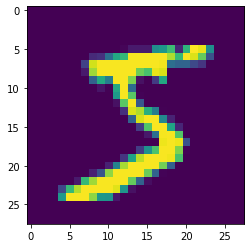

In [4]:
imshow(X_train[0]), Y_train[0]

In [5]:
# first step: recreate everything using pytorch
# conda install pytorch torchvision cpuonly -c pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.set_printoptions(sci_mode=False)
class BeneNet(torch.nn.Module):
  def __init__(self):
    super(BeneNet, self).__init__()
    self.l1 = nn.Linear(784, 128, bias=False)
    self.l2 = nn.Linear(128, 10, bias=False)
    self.sm = nn.LogSoftmax(dim=1)
  def forward(self, x):
    x = F.relu(self.l1(x))
    x = self.l2(x)
    x = self.sm(x)
    return x

In [6]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
class BeneNet(torch.nn.Module):
  def __init__(self):
    super(BeneNet, self).__init__()
    # fully connected for mnist
    self.l1 = nn.Linear(784, 128, bias = False)
    self.act = nn.ReLU()
    self.l2 = nn.Linear(128, 10, bias = False)
  def forward(self, x):
    x = self.l1(x)
    x = self.act(x)
    x = self.l2(x)
    return x

In [7]:
model = BeneNet()
model(torch.tensor(X_train[0:10].reshape((-1, 28*28))).float())
# model returns an array of class labels for every number. 
# multi class assignment problem =>
# we can use cross entropy loss to train the model

tensor([[-35.6955,   1.5012,   1.0992,  -3.0362,  16.7633,  35.7865, -14.6194,
          -3.5036, -47.2577,   6.0977],
        [-13.7004,  14.9275,  -4.2191,   3.8534,   5.3925,  13.6843,   0.3594,
         -18.1257, -31.6377,   8.6148],
        [ 13.2049, -17.5954,  12.7751,  11.8998,  21.7727,   2.4354,  30.0483,
         -22.6174,   5.7841,   0.3255],
        [  5.6310,   5.1095,  15.5769,  -5.8488,   2.9600,  19.2447,  17.2503,
         -38.0493,  -8.4929,   9.2608],
        [-45.1782,  20.4305,  11.2339,  -0.2551,  10.4746,  25.2544,   8.7203,
         -23.1349,  -9.8741,   2.1424],
        [ -7.0776, -27.6151,  -3.2807,   1.2498,   7.2096,  16.3235,   2.5981,
         -27.5160, -29.3564,  -2.3167],
        [  9.1667,  -0.5877,   5.6883,  -6.8510,  -8.8158,  30.6860, -17.1676,
          -7.0910,  -7.8999,   7.4471],
        [-29.6120, -11.5040,   5.6189, -14.5281,   8.8324,  16.4399, -17.4660,
         -19.3390, -45.2298,   5.3669],
        [  5.9775,  12.4754,  11.4680,   4.2557,

In [8]:
X_train.shape[0]

60000

In [9]:
BS = 32
loss_function = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0)
losses, accuracies = [], []

for i in (t := trange(1000)):
  samp = np.random.randint(0, X_train.shape[0], size =(BS))
  X = torch.tensor(X_train[samp].reshape((-1, 28*28))).float()
  Y = torch.tensor(Y_train[samp]).long()
  optim.zero_grad()
  out = model(X)
  # check for prediction accuracy
  cat = torch.argmax(out, dim = 1)
  accuracy = (cat == Y).float().mean()
  loss = loss_function(out, Y)
  loss.backward()
  optim.step()
  print(accuracy)
  loss, accuracy = loss.item(), accuracy.item()
  losses.append(loss)
  accuracies.append(accuracy)
  t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))


loss 1.78 accuracy 0.62:   3%|▎         | 30/1000 [00:00<00:03, 292.76it/s]

tensor(0.0625)
tensor(0.1875)
tensor(0.4688)
tensor(0.3125)
tensor(0.3750)
tensor(0.2812)
tensor(0.4375)
tensor(0.5000)
tensor(0.5000)
tensor(0.7188)
tensor(0.5938)
tensor(0.4688)
tensor(0.5625)
tensor(0.6562)
tensor(0.4062)
tensor(0.5625)
tensor(0.7188)
tensor(0.4688)
tensor(0.7500)
tensor(0.5000)
tensor(0.8125)
tensor(0.4062)
tensor(0.6875)
tensor(0.5938)
tensor(0.4688)
tensor(0.6875)
tensor(0.6250)
tensor(0.7500)
tensor(0.6562)
tensor(0.7500)
tensor(0.6562)
tensor(0.8125)
tensor(0.7188)
tensor(0.6875)
tensor(0.8438)
tensor(0.7188)
tensor(0.7812)
tensor(0.6875)
tensor(0.7500)
tensor(0.5312)
tensor(0.5312)
tensor(0.6875)
tensor(0.6875)
tensor(0.5938)
tensor(0.7500)
tensor(0.6250)
tensor(0.8438)
tensor(0.6875)
tensor(0.7500)
tensor(0.8125)
tensor(0.7188)
tensor(0.6562)
tensor(0.6875)
tensor(0.7500)
tensor(0.7188)
tensor(0.5938)
tensor(0.6250)


loss 0.56 accuracy 0.81:   9%|▉         | 92/1000 [00:00<00:03, 292.57it/s]

tensor(0.6562)
tensor(0.5938)
tensor(0.7500)
tensor(0.8438)
tensor(0.7812)
tensor(0.7812)
tensor(0.6250)
tensor(0.7812)
tensor(0.9062)
tensor(0.7812)
tensor(0.6875)
tensor(0.7500)
tensor(0.8125)
tensor(0.6875)
tensor(0.8750)
tensor(0.6875)
tensor(0.8750)
tensor(0.7500)
tensor(0.9062)
tensor(0.7500)
tensor(0.5938)
tensor(0.8438)
tensor(0.7500)
tensor(0.8438)
tensor(0.6250)
tensor(0.5938)
tensor(0.8750)
tensor(0.7812)
tensor(0.9688)
tensor(0.8438)
tensor(0.8438)
tensor(0.7188)
tensor(0.7188)
tensor(0.7812)
tensor(0.7188)
tensor(0.8438)
tensor(0.8750)
tensor(0.7500)
tensor(0.7812)
tensor(0.7188)
tensor(0.8125)
tensor(0.8438)
tensor(0.8125)
tensor(0.7500)
tensor(0.8750)
tensor(0.8438)
tensor(0.8750)
tensor(0.7188)
tensor(0.8125)
tensor(0.8438)
tensor(0.7500)
tensor(0.8750)
tensor(0.8438)
tensor(0.8125)


loss 0.28 accuracy 0.88:  16%|█▌        | 158/1000 [00:00<00:02, 306.94it/s]

tensor(0.7812)
tensor(0.6562)
tensor(0.8750)
tensor(0.7812)
tensor(0.7500)
tensor(0.7812)
tensor(0.7188)
tensor(0.6250)
tensor(0.7812)
tensor(0.7812)
tensor(0.7500)
tensor(0.8438)
tensor(0.8125)
tensor(0.8125)
tensor(0.6562)
tensor(0.7812)
tensor(0.7188)
tensor(0.8438)
tensor(0.7812)
tensor(0.7812)
tensor(0.7188)
tensor(0.7500)
tensor(0.7812)
tensor(0.9062)
tensor(0.8438)
tensor(0.7500)
tensor(0.7500)
tensor(0.8750)
tensor(0.7812)
tensor(0.8438)
tensor(0.8750)
tensor(0.7500)
tensor(0.9375)
tensor(0.8750)
tensor(0.9375)
tensor(0.7812)
tensor(0.8125)
tensor(0.8438)
tensor(0.7500)
tensor(0.8125)
tensor(0.9062)
tensor(0.9375)
tensor(0.8125)
tensor(0.8125)
tensor(0.9062)
tensor(0.7812)
tensor(0.8438)
tensor(0.7812)
tensor(0.7812)
tensor(0.7188)
tensor(0.8750)
tensor(0.8125)
tensor(0.8438)
tensor(0.7500)
tensor(0.8438)
tensor(0.7500)
tensor(0.8125)
tensor(0.7188)
tensor(0.6875)
tensor(0.7812)
tensor(0.8750)


loss 0.58 accuracy 0.78:  22%|██▎       | 225/1000 [00:00<00:02, 317.08it/s]

tensor(0.8750)
tensor(0.6250)
tensor(0.9375)
tensor(0.8438)
tensor(0.8438)
tensor(0.6875)
tensor(0.7500)
tensor(0.7188)
tensor(0.9062)
tensor(0.7812)
tensor(0.8750)
tensor(0.8438)
tensor(0.8438)
tensor(0.8750)
tensor(0.7188)
tensor(0.8438)
tensor(0.8125)
tensor(0.9688)
tensor(0.9375)
tensor(0.8750)
tensor(0.7500)
tensor(0.7188)
tensor(0.8750)
tensor(0.6875)
tensor(0.8438)
tensor(0.7812)
tensor(0.8125)
tensor(0.7812)
tensor(0.9375)
tensor(0.7500)
tensor(0.8750)
tensor(0.7188)
tensor(0.9688)
tensor(0.9062)
tensor(0.8750)
tensor(0.9062)
tensor(0.8750)
tensor(0.8750)
tensor(0.8750)
tensor(0.8438)
tensor(0.9375)
tensor(0.7500)
tensor(0.9375)
tensor(0.7500)
tensor(0.8750)
tensor(0.9062)
tensor(0.9688)
tensor(0.8750)
tensor(0.8125)
tensor(0.7188)
tensor(0.8438)
tensor(0.7500)
tensor(0.7812)
tensor(0.8438)
tensor(0.8750)
tensor(0.8750)
tensor(0.9062)
tensor(0.8438)
tensor(0.7812)
tensor(0.8750)


loss 0.38 accuracy 0.91:  29%|██▉       | 289/1000 [00:00<00:02, 314.44it/s]

tensor(0.7500)
tensor(0.8125)
tensor(0.8438)
tensor(0.8750)
tensor(0.7812)
tensor(0.8438)
tensor(0.9688)
tensor(0.8750)
tensor(0.8438)
tensor(0.9688)
tensor(0.7500)
tensor(0.9688)
tensor(0.8750)
tensor(0.9062)
tensor(0.8750)
tensor(0.7812)
tensor(0.8438)
tensor(0.8125)
tensor(0.9062)
tensor(0.9062)
tensor(0.9062)
tensor(0.7812)
tensor(0.8438)
tensor(0.9062)
tensor(0.7500)
tensor(0.9062)
tensor(0.9688)
tensor(0.8438)
tensor(0.8125)
tensor(0.8750)
tensor(0.9688)
tensor(0.7812)
tensor(0.8125)
tensor(0.7188)
tensor(0.9375)
tensor(0.8438)
tensor(0.8438)
tensor(0.8438)
tensor(0.9375)
tensor(0.9062)
tensor(0.8438)
tensor(0.8125)
tensor(0.8438)
tensor(0.8438)
tensor(0.9375)
tensor(0.7188)
tensor(0.7812)
tensor(0.9062)
tensor(0.9062)
tensor(0.8438)
tensor(0.9062)
tensor(0.9375)
tensor(0.9062)
tensor(0.7188)
tensor(0.9375)
tensor(0.6875)
tensor(0.8750)
tensor(0.9062)


loss 0.27 accuracy 0.91:  32%|███▏      | 321/1000 [00:01<00:02, 315.11it/s]

tensor(0.8438)
tensor(0.7812)
tensor(0.9688)
tensor(0.9375)
tensor(0.8438)
tensor(0.8438)
tensor(0.9688)
tensor(0.8438)
tensor(0.8438)
tensor(0.9062)
tensor(1.)
tensor(0.7812)
tensor(0.8125)
tensor(0.9062)
tensor(0.8438)
tensor(0.7812)
tensor(0.7812)
tensor(0.7812)
tensor(0.8125)
tensor(0.8438)
tensor(0.8750)
tensor(0.8125)
tensor(0.9375)
tensor(0.8438)
tensor(0.8125)
tensor(0.8750)
tensor(0.8125)
tensor(0.8125)
tensor(0.8438)
tensor(0.9062)
tensor(0.9062)
tensor(0.9062)
tensor(0.8438)
tensor(0.8438)
tensor(0.7812)
tensor(0.9375)
tensor(0.9688)
tensor(0.9062)
tensor(0.8438)
tensor(0.8750)
tensor(0.9375)
tensor(0.8438)
tensor(0.9062)
tensor(0.8438)
tensor(0.8750)
tensor(0.9375)
tensor(0.8750)
tensor(0.8438)
tensor(0.8125)
tensor(0.8750)
tensor(0.9688)
tensor(0.8438)
tensor(0.7500)
tensor(0.8438)
tensor(0.9375)
tensor(0.8125)
tensor(0.9062)
tensor(0.9062)
tensor(0.9062)


loss 0.52 accuracy 0.88:  38%|███▊      | 385/1000 [00:01<00:01, 310.89it/s]

tensor(0.8750)
tensor(0.8750)
tensor(0.7500)
tensor(0.8750)
tensor(0.9375)
tensor(0.9062)
tensor(0.9375)
tensor(0.6875)
tensor(0.9062)
tensor(0.8438)
tensor(0.8750)
tensor(0.9062)
tensor(0.8125)
tensor(0.7812)
tensor(0.7812)
tensor(0.9062)
tensor(0.8438)
tensor(0.8125)
tensor(0.8750)
tensor(0.9688)
tensor(0.9375)
tensor(0.8438)
tensor(0.8125)
tensor(0.8750)
tensor(0.9375)
tensor(0.8438)
tensor(0.8438)
tensor(1.)
tensor(0.9375)
tensor(0.8438)
tensor(0.9062)
tensor(0.8438)
tensor(0.8438)
tensor(0.9062)
tensor(0.9062)
tensor(0.8750)
tensor(0.9062)
tensor(0.8438)
tensor(0.9062)
tensor(0.9062)
tensor(0.8125)
tensor(0.9375)
tensor(0.8750)
tensor(0.9062)
tensor(0.8750)
tensor(0.9375)
tensor(0.6562)
tensor(0.9062)
tensor(0.7500)
tensor(0.9375)
tensor(0.8750)
tensor(0.9062)
tensor(0.9688)
tensor(1.)
tensor(0.8438)
tensor(0.8438)
tensor(0.9375)
tensor(0.8750)
tensor(0.9375)

loss 0.45 accuracy 0.88:  45%|████▌     | 451/1000 [00:01<00:01, 318.18it/s]


tensor(0.8438)
tensor(0.9375)
tensor(0.9062)
tensor(0.8438)
tensor(0.9375)
tensor(0.8438)
tensor(0.9062)
tensor(0.8750)
tensor(0.9375)
tensor(0.9062)
tensor(0.9062)
tensor(0.8438)
tensor(0.8750)
tensor(0.6875)
tensor(0.9688)
tensor(0.9062)
tensor(0.9375)
tensor(0.8125)
tensor(0.8125)
tensor(0.8125)
tensor(0.9688)
tensor(0.9062)
tensor(0.7812)
tensor(0.8750)
tensor(0.9062)
tensor(0.8750)
tensor(0.9688)
tensor(0.7188)
tensor(0.9375)
tensor(0.9062)
tensor(0.9062)
tensor(0.8125)
tensor(1.)
tensor(0.9375)
tensor(0.9375)
tensor(0.8438)
tensor(0.7812)
tensor(0.9375)
tensor(0.9375)
tensor(0.9062)
tensor(0.9688)
tensor(0.9062)
tensor(0.9375)
tensor(0.9062)
tensor(0.8750)
tensor(0.8125)
tensor(0.8438)
tensor(0.9375)
tensor(0.9375)
tensor(0.9062)
tensor(0.9375)
tensor(0.9688)
tensor(0.9062)
tensor(0.9062)
tensor(0.9062)
tensor(0.9375)
tensor(0.9375)
tensor(0.8750)
tensor(0.9375)
tensor(0.9375)
tensor(0.8750)


loss 0.40 accuracy 0.84:  52%|█████▏    | 518/1000 [00:01<00:01, 319.39it/s]

tensor(0.8750)
tensor(0.8438)
tensor(0.9375)
tensor(0.8750)
tensor(0.9688)
tensor(0.9375)
tensor(0.8750)
tensor(0.7812)
tensor(0.7812)
tensor(0.8750)
tensor(0.8438)
tensor(0.8750)
tensor(0.9688)
tensor(0.9375)
tensor(0.9375)
tensor(0.9062)
tensor(0.9375)
tensor(0.9375)
tensor(0.9375)
tensor(0.8750)
tensor(0.9375)
tensor(0.8750)
tensor(0.9062)
tensor(0.9062)
tensor(0.9062)
tensor(0.8750)
tensor(0.9062)
tensor(0.9375)
tensor(0.8750)
tensor(0.9375)
tensor(0.9375)
tensor(0.8750)
tensor(0.9062)
tensor(0.8750)
tensor(0.9062)
tensor(0.8750)
tensor(0.8125)
tensor(0.9062)
tensor(0.9062)
tensor(0.8438)
tensor(0.7812)
tensor(0.9375)
tensor(0.9062)
tensor(0.8125)
tensor(0.8750)
tensor(1.)
tensor(0.8125)
tensor(0.9062)
tensor(0.9375)
tensor(0.8750)
tensor(0.9062)
tensor(0.8125)
tensor(0.8750)
tensor(0.9062)
tensor(0.9375)
tensor(0.9062)
tensor(0.8438)
tensor(0.9062)
tensor(0.8438)


loss 0.20 accuracy 0.91:  58%|█████▊    | 584/1000 [00:01<00:01, 318.40it/s]

tensor(0.9375)
tensor(0.8750)
tensor(0.9062)
tensor(0.9062)
tensor(0.9688)
tensor(0.9375)
tensor(0.8750)
tensor(0.8125)
tensor(0.9062)
tensor(0.9688)
tensor(0.9375)
tensor(0.9062)
tensor(0.8438)
tensor(0.9062)
tensor(0.8125)
tensor(0.8125)
tensor(0.8750)
tensor(0.8750)
tensor(0.9062)
tensor(0.9375)
tensor(0.8438)
tensor(0.8750)
tensor(0.9062)
tensor(0.9688)
tensor(0.8750)
tensor(0.9375)
tensor(0.9375)
tensor(0.9688)
tensor(0.9062)
tensor(0.8750)
tensor(0.8438)
tensor(0.9375)
tensor(0.8438)
tensor(0.9062)
tensor(0.9375)
tensor(0.8750)
tensor(0.9062)
tensor(0.8125)
tensor(0.8125)
tensor(0.7812)
tensor(0.8750)
tensor(0.8438)
tensor(0.8750)
tensor(0.9375)
tensor(0.8750)
tensor(0.9375)
tensor(0.9062)
tensor(0.8750)
tensor(0.8438)
tensor(0.9062)
tensor(0.9688)
tensor(0.9375)
tensor(0.9375)
tensor(0.8750)
tensor(0.8750)
tensor(0.9062)
tensor(0.8750)
tensor(0.9062)
tensor(0.8438)
tensor(0.9062)


loss 0.30 accuracy 0.94:  62%|██████▏   | 619/1000 [00:02<00:01, 326.31it/s]

tensor(0.9375)
tensor(0.9688)
tensor(0.9062)
tensor(0.9062)
tensor(0.8438)
tensor(0.9375)
tensor(0.9062)
tensor(0.9375)
tensor(0.9375)
tensor(0.9375)
tensor(0.9375)
tensor(0.9688)
tensor(0.8750)
tensor(0.9688)
tensor(0.8750)
tensor(0.9375)
tensor(0.9688)
tensor(0.9062)
tensor(0.8438)
tensor(0.8750)
tensor(0.9062)
tensor(0.9062)
tensor(0.8125)
tensor(0.8125)
tensor(0.7500)
tensor(0.8750)
tensor(0.9688)
tensor(0.9062)
tensor(0.9375)
tensor(0.8125)
tensor(0.8125)
tensor(0.8750)
tensor(0.8438)
tensor(0.9375)
tensor(0.9062)
tensor(0.8750)
tensor(0.9375)
tensor(0.9688)
tensor(0.9375)
tensor(0.9375)
tensor(0.8438)
tensor(0.8438)
tensor(0.9062)
tensor(0.9375)
tensor(0.9375)
tensor(0.9062)
tensor(0.8438)
tensor(0.8750)
tensor(0.9375)
tensor(0.9062)
tensor(0.8438)
tensor(0.9688)
tensor(1.)
tensor(0.8750)
tensor(0.9375)
tensor(0.9375)
tensor(0.9375)
tensor(0.9062)
tensor(0.9375)
tensor(0.8750)
tensor(0.8750)
tensor(0.9062)
tensor(1.)
tensor(0.9375)
tensor(1.)

loss 0.25 accuracy 0.91:  69%|██████▊   | 687/1000 [00:02<00:00, 328.26it/s]


tensor(0.9688)
tensor(0.8438)
tensor(0.9688)
tensor(0.9062)
tensor(0.8438)
tensor(0.8750)
tensor(0.9688)
tensor(0.9375)
tensor(0.8438)
tensor(0.9375)
tensor(0.9688)
tensor(0.9375)
tensor(0.8438)
tensor(0.9375)
tensor(0.8125)
tensor(0.8438)
tensor(0.9062)
tensor(0.9062)
tensor(0.9062)
tensor(0.9062)
tensor(0.8438)
tensor(0.9688)
tensor(0.9375)
tensor(0.8750)
tensor(1.)
tensor(0.9375)
tensor(0.8750)
tensor(0.8125)
tensor(0.8750)
tensor(0.8750)
tensor(0.8125)
tensor(0.8438)
tensor(0.8438)
tensor(1.)
tensor(0.9375)
tensor(0.8750)
tensor(0.9062)
tensor(0.8438)
tensor(0.8125)
tensor(0.9062)
tensor(0.9062)
tensor(0.8750)
tensor(0.9688)
tensor(0.9375)
tensor(0.8438)
tensor(0.9688)
tensor(0.9688)
tensor(0.9375)
tensor(0.9062)
tensor(0.9375)
tensor(0.9688)
tensor(0.8125)
tensor(0.9375)
tensor(0.9375)
tensor(0.9062)
tensor(0.9375)
tensor(0.8438)
tensor(1.)
tensor(0.9062)
tensor(0.9062)
tensor(0.9375)

loss 0.43 accuracy 0.94:  75%|███████▌  | 753/1000 [00:02<00:00, 326.09it/s]


tensor(0.9062)
tensor(0.9375)
tensor(0.9375)
tensor(0.9062)
tensor(0.9375)
tensor(0.8750)
tensor(0.9688)
tensor(0.8750)
tensor(0.9688)
tensor(0.9062)
tensor(0.8750)
tensor(0.8750)
tensor(0.9375)
tensor(0.9062)
tensor(0.8750)
tensor(0.9375)
tensor(0.8750)
tensor(0.8438)
tensor(0.9375)
tensor(0.8125)
tensor(0.9062)
tensor(0.8750)
tensor(0.8750)
tensor(0.9062)
tensor(0.9688)
tensor(0.9062)
tensor(0.8750)
tensor(0.9688)
tensor(0.9375)
tensor(0.9062)
tensor(0.8750)
tensor(0.9062)
tensor(0.8125)
tensor(0.9062)
tensor(0.8750)
tensor(0.8750)
tensor(0.9688)
tensor(0.9375)
tensor(0.9375)
tensor(0.8438)
tensor(0.8438)
tensor(0.9062)
tensor(0.9062)
tensor(0.9062)
tensor(0.9062)
tensor(0.9375)
tensor(0.9688)
tensor(0.9062)
tensor(0.9375)
tensor(0.8750)
tensor(0.9375)
tensor(0.9688)
tensor(0.9375)
tensor(0.9375)
tensor(0.8438)
tensor(0.9062)
tensor(0.8750)
tensor(0.9375)
tensor(0.8750)

loss 0.56 accuracy 0.88:  82%|████████▏ | 820/1000 [00:02<00:00, 323.39it/s]


tensor(0.9688)
tensor(0.9062)
tensor(0.9688)
tensor(0.9062)
tensor(0.9062)
tensor(0.9062)
tensor(0.9375)
tensor(0.8438)
tensor(0.9062)
tensor(0.9688)
tensor(0.8750)
tensor(0.8750)
tensor(0.8750)
tensor(0.9062)
tensor(0.9688)
tensor(0.8438)
tensor(0.9062)
tensor(0.8750)
tensor(0.8438)
tensor(0.9375)
tensor(0.9062)
tensor(0.9688)
tensor(0.9375)
tensor(0.9062)
tensor(0.9062)
tensor(0.8438)
tensor(0.9375)
tensor(0.9375)
tensor(0.9375)
tensor(0.9062)
tensor(0.8438)
tensor(0.9688)
tensor(1.)
tensor(0.9062)
tensor(0.9062)
tensor(0.8438)
tensor(0.9062)
tensor(0.8438)
tensor(0.9688)
tensor(0.8750)
tensor(0.8438)
tensor(0.9062)
tensor(0.9375)
tensor(1.)
tensor(0.8750)
tensor(1.)
tensor(0.9062)
tensor(0.9062)
tensor(0.9062)
tensor(0.9688)
tensor(0.9688)
tensor(1.)
tensor(0.9062)
tensor(0.9375)
tensor(0.9375)
tensor(0.9375)
tensor(0.9688)
tensor(0.9688)
tensor(0.9062)
tensor(0.8750)


loss 0.06 accuracy 0.97:  88%|████████▊ | 885/1000 [00:02<00:00, 313.81it/s]

tensor(0.9062)
tensor(0.9375)
tensor(0.8750)
tensor(0.9375)
tensor(0.9062)
tensor(0.9688)
tensor(0.9688)
tensor(0.8438)
tensor(0.8750)
tensor(0.9688)
tensor(0.9062)
tensor(0.8750)
tensor(0.7812)
tensor(0.8750)
tensor(1.)
tensor(0.9062)
tensor(0.9062)
tensor(0.9062)
tensor(0.9688)
tensor(1.)
tensor(0.9375)
tensor(0.8438)
tensor(1.)
tensor(0.9375)
tensor(0.9062)
tensor(0.8750)
tensor(0.8750)
tensor(0.9688)
tensor(0.9375)
tensor(0.8125)
tensor(0.9062)
tensor(0.8750)
tensor(0.9062)
tensor(0.8750)
tensor(0.9375)
tensor(0.9062)
tensor(0.9062)
tensor(0.9375)
tensor(1.)
tensor(0.9688)
tensor(0.9375)
tensor(0.9062)
tensor(0.9062)
tensor(0.9062)
tensor(0.8750)
tensor(0.9375)
tensor(0.9375)
tensor(0.8438)
tensor(0.8750)
tensor(0.9062)
tensor(0.9062)
tensor(0.8750)
tensor(0.9688)
tensor(0.8438)
tensor(0.9688)
tensor(1.)

loss 0.04 accuracy 1.00:  92%|█████████▏| 917/1000 [00:02<00:00, 306.56it/s]


tensor(0.8750)
tensor(0.9375)
tensor(0.9375)
tensor(0.9062)
tensor(0.9375)
tensor(0.9062)
tensor(0.9062)
tensor(0.9375)
tensor(0.9688)
tensor(0.9375)
tensor(0.9375)
tensor(0.8750)
tensor(0.9062)
tensor(0.9375)
tensor(0.9375)
tensor(0.9375)
tensor(0.9062)
tensor(0.9375)
tensor(0.9062)
tensor(0.9688)
tensor(0.9062)
tensor(1.)
tensor(0.8750)
tensor(0.9062)
tensor(0.9688)
tensor(0.9688)
tensor(0.8750)
tensor(0.9062)
tensor(1.)
tensor(0.9688)
tensor(0.9375)
tensor(0.7188)
tensor(0.9688)
tensor(1.)
tensor(0.9375)
tensor(0.9688)
tensor(0.9062)
tensor(0.8750)
tensor(0.9688)
tensor(0.9688)
tensor(0.8125)
tensor(0.9062)
tensor(0.9688)
tensor(0.9375)
tensor(0.9062)
tensor(0.9062)
tensor(0.9062)
tensor(0.9688)
tensor(0.9062)
tensor(0.9375)
tensor(1.)
tensor(0.9062)
tensor(0.9375)
tensor(0.9375)
tensor(0.9375)
tensor(0.9688)
tensor(1.)
tensor(0.8438)
tensor(0.9062)
tensor(1.)
tensor(0.9062)


loss 0.12 accuracy 0.97: 100%|██████████| 1000/1000 [00:03<00:00, 316.30it/s]

tensor(0.9062)
tensor(0.9062)
tensor(0.7812)
tensor(0.9062)
tensor(0.9375)
tensor(0.8750)
tensor(0.9375)
tensor(0.9688)
tensor(0.8750)
tensor(0.9688)
tensor(0.8750)
tensor(0.9688)
tensor(0.9375)
tensor(0.9062)
tensor(0.9062)
tensor(0.8125)
tensor(0.9375)
tensor(0.8750)
tensor(0.8125)
tensor(0.9062)
tensor(0.9375)
tensor(0.8438)
tensor(0.9375)
tensor(0.8438)
tensor(0.9375)
tensor(0.9375)
tensor(1.)
tensor(0.9062)
tensor(0.8438)
tensor(0.9062)
tensor(0.8750)
tensor(0.9062)
tensor(0.9062)
tensor(0.9375)
tensor(0.9688)
tensor(0.9688)
tensor(1.)
tensor(0.9062)
tensor(0.9375)
tensor(0.9062)
tensor(0.9375)
tensor(0.9062)
tensor(0.8125)
tensor(0.9062)
tensor(0.8750)
tensor(0.8438)
tensor(0.8438)
tensor(0.9062)
tensor(1.)
tensor(0.9688)


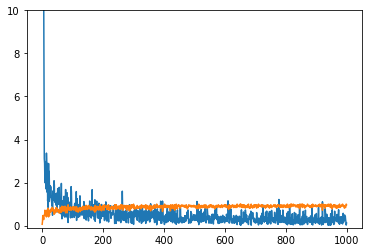

In [11]:
plt.ylim(-0.1, 10)
plot(losses)
plot(accuracies)


In [12]:
# evaluate performance
Y_test_preds = torch.argmax(model(torch.tensor(X_test.reshape((-1, 28*28))).float()), dim = 1).numpy()
(Y_test == Y_test_preds).mean()

0.9239

In [13]:
# trying to recreate everything from scratch #
# initialize the network
l1 = np.zeros((784, 128), dtype = np.float32)
l2 = np.zeros((128, 10), dtype = np.float32)
l1.dtype, l2.dtype

(dtype('float32'), dtype('float32'))

In [ ]:
l1 = model.l1.weight.detach().numpy()